# ARIMA model in stock price prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas.plotting import lag_plot
from pylab import rcParams

import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data Preparation

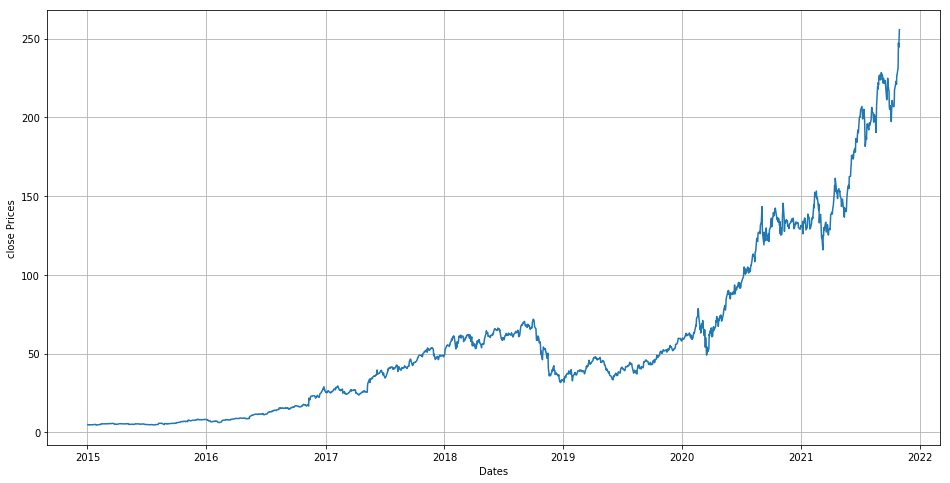

In [5]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('NVidia_stock_history.csv', 
                   parse_dates=['Date'], index_col='Date',date_parser=dateparse)
data=data.iloc[4013:-10,0:11]  #start at 2015
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('close Prices')
plt.plot(data['Close'])

In [6]:
#test_data

### The charts above shows a high correlation between y(t) and y(t+1).

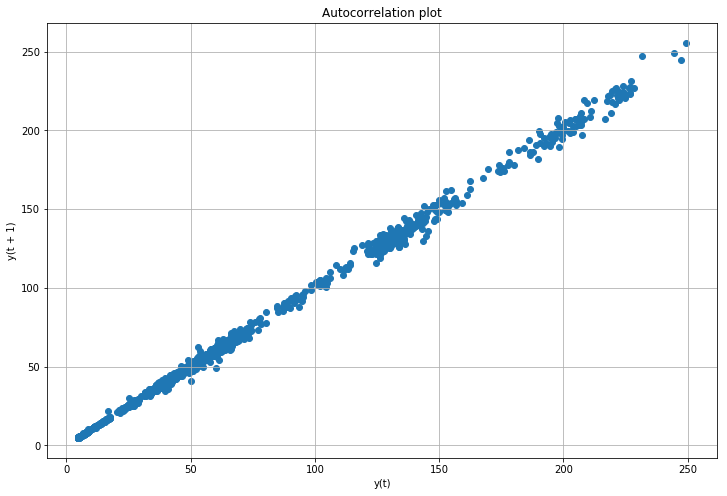

In [7]:
plt.figure(figsize=(12,8))
lag_plot(data['Close'], lag=1)
plt.title('Autocorrelation plot')
plt.grid(True)
#此图说明数据有自相关性

### Checking correlation by calculating covariance:

In [8]:
#查看自相关性
values = DataFrame(data['Close'].values)
dataframe = concat([values.shift(1),values.shift(5),values.shift(10),values.shift(30), values], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
result = dataframe.corr()
print(result)

             t       t+1       t+5      t+10      t+30
t     1.000000  0.997297  0.994183  0.985304  0.999274
t+1   0.997297  1.000000  0.996771  0.986275  0.996683
t+5   0.994183  0.996771  1.000000  0.988337  0.993443
t+10  0.985304  0.986275  0.988337  1.000000  0.985114
t+30  0.999274  0.996683  0.993443  0.985114  1.000000


In [9]:
from statsmodels.graphics import tsaplots

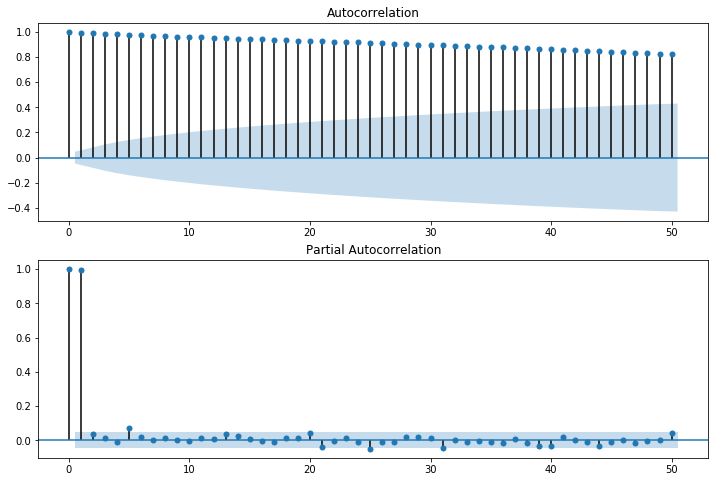

In [10]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(data['Close'], lags=50, alpha=0.05, ax=ax1)
ax2 = fig.add_subplot(212)
fig = tsaplots.plot_pacf(data['Close'], lags=50, alpha=0.05, ax=ax2)
#下图说明愿数据不平稳，需要进行处理

In [11]:
train_data, test_data = data[0:-100], data[-100:]

# AR

In [12]:
#可以不平稳
train_ar = train_data['Close'].dropna() #删掉空值 选择close value作为训练数据
test_ar = test_data['Close']

model = AR(train_ar)
model_fit = model.fit()
#训练模型后得到的参数： AR的之后项个数p，和自回归函数的各个系数
coef = model_fit.params
p = model_fit.k_ar  # 即时间序列模型中常见的p，即AR(p), ARMA(p,q), ARIMA(p,d,q)中的p。
# p的实际含义，此处得到p=24，意味着当天由最近24天预测。
window = 1 #built ar 1 model
history = train_ar[len(train_ar)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()

for t in range(len(test_ar)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    #print(window)
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test_ar[t]
    predictions.append(yhat+22)
    history.append(obs)
    
print('MSE: '+str(mean_squared_error(test_data['Close'], predictions)))
print('MAE: '+str(mean_absolute_error(test_data['Close'], predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['Close'], predictions))))

MSE: 46.34421792513785
MAE: 5.472446949780711
RMSE: 6.807658769734118


Lag: 24


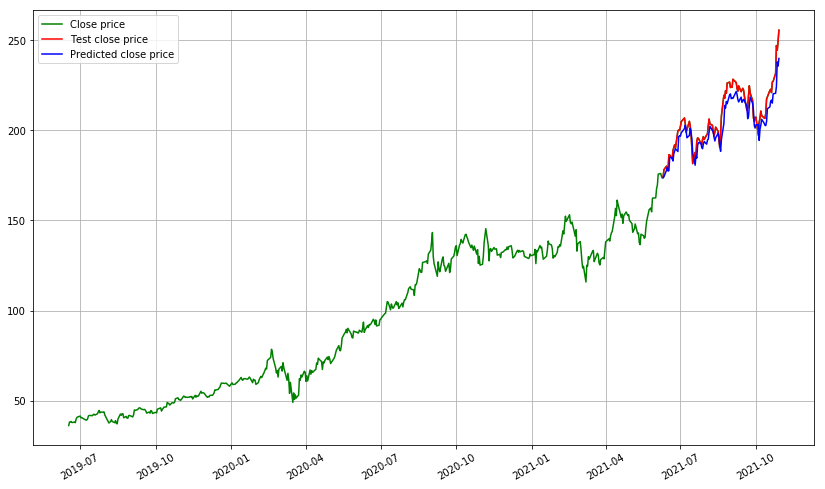

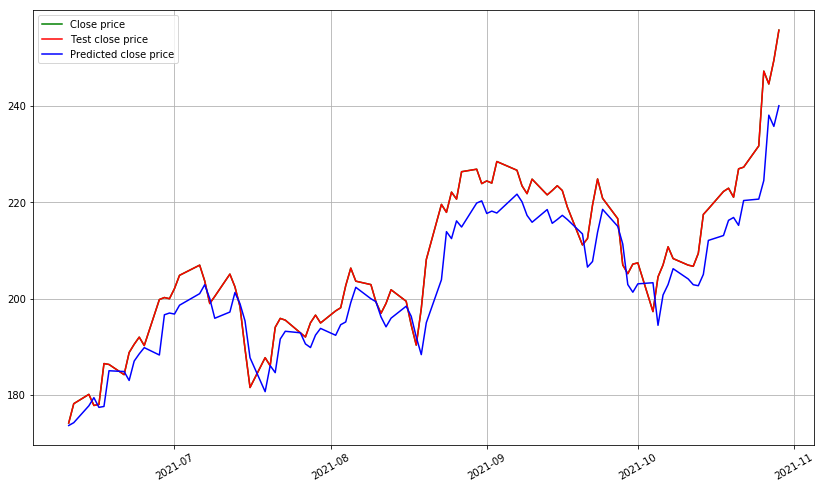

In [13]:
plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Close'].tail(600), color='green', label='Close price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Test close price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted close price')
#plt.plot(pred.index[-100:], pred[-100:], color='blue', label='Predicted close price')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()
plt.figure(figsize=(14,8))
print('Lag: %s' % model_fit.k_ar)
plt.plot(data.index[-100:], data['Close'].tail(100), color='green', label='Close price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Test close price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted close price')
#plt.plot(pred.index[-100:], pred[-100:], color='blue', label='Predicted close price')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()

# MA

In [14]:
train_ma = train_data['Close'].dropna()
test_ma = test_data['Close']
history = [x for x in train_ma]
y = test_ma
predictions = list()


model = ARMA(history, order=(0,1))
model_fit = model.fit(disp= -1)
q = model_fit.k_ar 
print(q)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])

for i in range(1, len(y)):
    model = ARMA(history, order=(0,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat+70)
    obs = y[i]
    history.append(obs)
    
    
    
print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

0
MSE: 200.88513323074633
MAE: 10.852043450964263
RMSE: 14.17339526121904


In [15]:
yhat = model_fit.forecast()[0]
print(yhat)

[152.92129464]


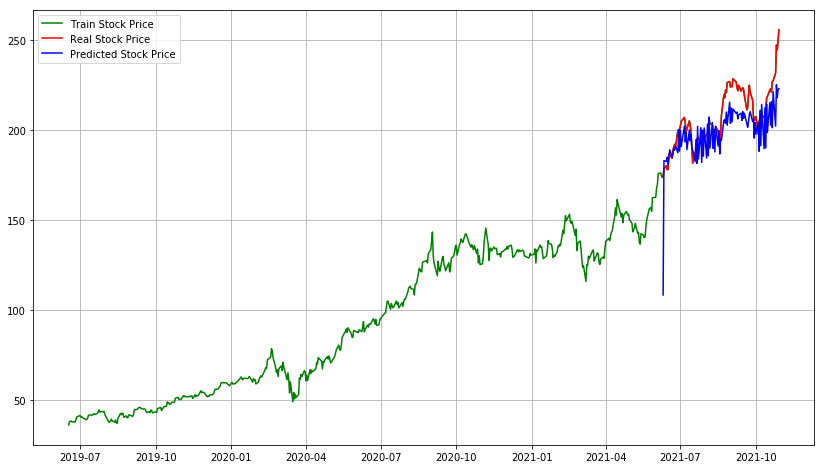

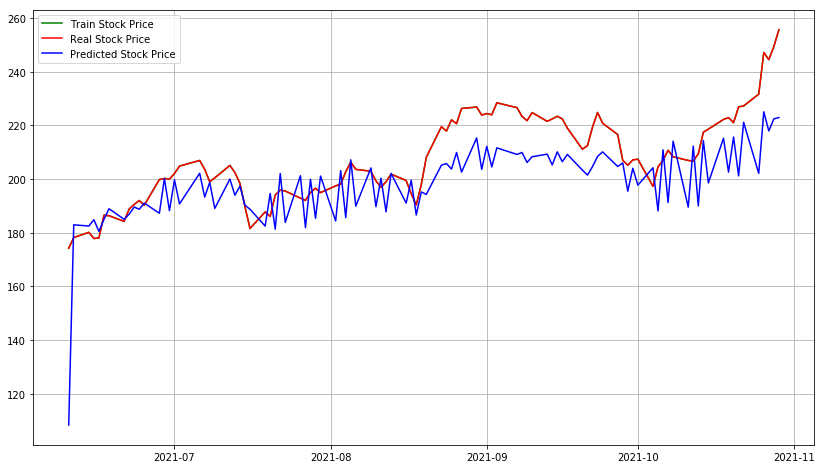

In [16]:
plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Close'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(14,8))
plt.plot(data.index[-100:], data['Close'].tail(100), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# ARMA

Difference.


In [17]:
def test_stationarity(timeseries):
    rolmean = pd.Series.rolling(timeseries,window=12).mean()
    rolstd = pd.Series.rolling(timeseries, window=12).std()
    fig = plt.figure()
    fig.add_subplot()
    orig = plt.plot(timeseries, color = 'blue',label='Original')
    mean = plt.plot(rolmean , color = 'red',label = 'rolling mean')
    std = plt.plot(rolstd, color = 'black', label= 'Rolling standard deviation')
    plt.ylim([-30,30])
    
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print( 'Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    print(dfoutput)
    
#ts_log = data['Close']
#ts_log_diff = ts_log - ts_log.shift()
#ts_log_diff.dropna(inplace=True)


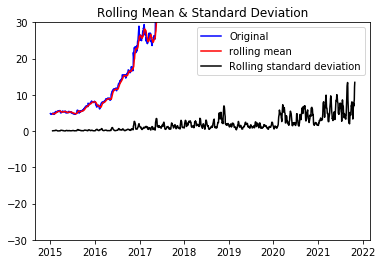

Results of Dickey-Fuller Test:
Test Statistic                    3.787452
p-value                           1.000000
#Lags Used                       25.000000
Number of Observations Used    1694.000000
Critical value (1%)              -3.434216
Critical value (5%)              -2.863248
Critical value (10%)             -2.567679
dtype: float64


In [18]:
test_stationarity(data['Close'])

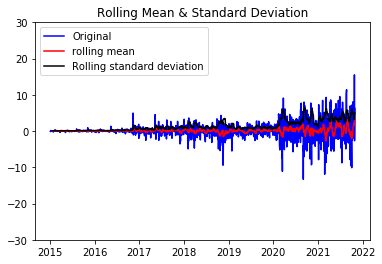

Results of Dickey-Fuller Test:
Test Statistic                -8.539803e+00
p-value                        9.853139e-14
#Lags Used                     2.500000e+01
Number of Observations Used    1.693000e+03
Critical value (1%)           -3.434218e+00
Critical value (5%)           -2.863249e+00
Critical value (10%)          -2.567680e+00
dtype: float64


In [19]:
datadif = data['Close'].diff()
datadif.dropna(inplace = True)
test_stationarity(datadif)

In [20]:
#通过测试，是平稳的
#测试是否为白噪声序列，若是则停止分析
from statsmodels.stats.diagnostic import acorr_ljungbox

In [21]:
lbvalue,pvalue = acorr_ljungbox(datadif,lags=5)
pvalue

array([0.03483478, 0.01757889, 0.02981796, 0.04838994, 0.05984103])

In [22]:
#变化不大，换一个方法
#平滑法  对size个数据进行加权移动平均
def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    
    
    # 对size个数据进行加权移动平均
    rol_weighted_mean = pd.DataFrame.ewm(timeSeries, span=size).mean()

    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()
    return rol_weighted_mean

    
#dffff = draw_trend(ts_log_diff,12)
#test_stationarity(dffff)  #是所有的open data做平滑，后面test也可以用这个

怎么确定pq值？

In [23]:
from statsmodels.graphics import tsaplots

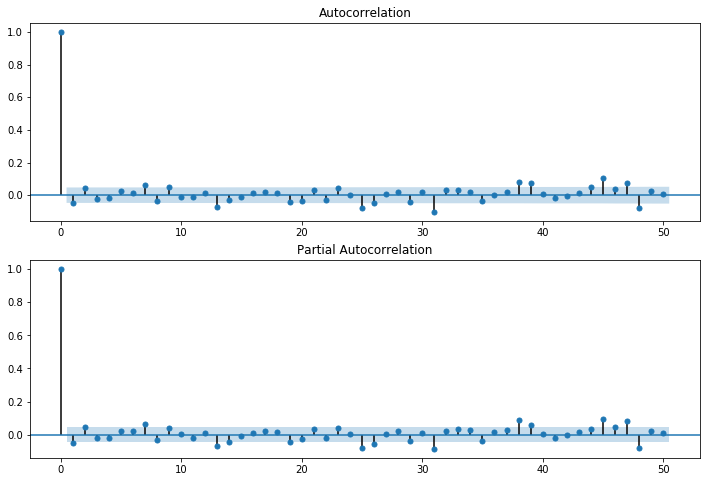

In [24]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(datadif, lags=50, alpha=0.05, ax=ax1)
ax2 = fig.add_subplot(212)
fig = tsaplots.plot_pacf(datadif, lags=50, alpha=0.05, ax=ax2)

### ARMA process with data after difference:

In [25]:
datadif = datadif[1400:]
print(len(datadif))

319


In [26]:
#两个模型的RMSE能不能直接比较 跟数据预处理是不是有影响？
#使用滚动窗口
testdata = data[-90:]
train_arma, test_arma = datadif[0:-100], datadif[-100:]

In [27]:
import  statsmodels.tsa.stattools as sts
resid = sts.arma_order_select_ic(train_arma , max_ar=5, max_ma=5,ic=['aic','bic','hqic'], trend='nc', fit_kw=dict(method='css'))
print ('AIC-order :{}'.format(resid.aic_min_order))
print ('BIC-order :{}'.format(resid.bic_min_order))
print ('HQIC-order :{}'.format(resid.hqic_min_order))

AIC-order :(5, 3)
BIC-order :(5, 3)
HQIC-order :(5, 3)


In [28]:
from statsmodels.tsa.arima.model import ARIMA

In [29]:

history = [x for x in train_arma]
#y=draw_trend(test_arma, 12)
y=test_arma
predictions = list()
model = ARIMA(history, order=(1,0,0))  #(p,1,q)
model_fit = model.fit()
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])

for i in range(1, len(y)):
    model = ARIMA(history, order=(1,0,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat+2)
    obs = y[i]
    history.append(obs)

print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

MSE: 22.773437147984318
MAE: 3.7363416338492677
RMSE: 4.772152255322992


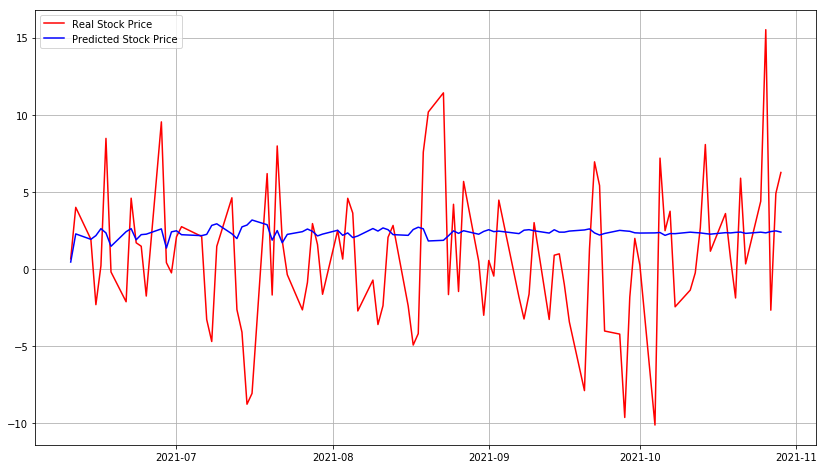

In [30]:
plt.figure(figsize=(14,8))
plt.plot(test_arma.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_arma.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  318
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -890.228
Date:                Mon, 16 May 2022   AIC                           1786.456
Time:                        11:00:37   BIC                           1797.742
Sample:                             0   HQIC                          1790.964
                                - 318                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4570      0.221      2.070      0.038       0.024       0.890
ar.L1         -0.0133      0.049     -0.273      0.785      -0.109       0.082
sigma2        15.8159      1.036     15.272      0.000      13.786      17.846
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.36
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.03
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#把prediction还原成差分前的数据

ye = pd.Series(predictions)
prevy= test_data['Close']

#print(ye)

yre=ye.cumsum()+prevy.values[-1]
#print(yre)

#还原y的预测值
y_restored = pd.Series([prevy[0]], index=[prevy.index[0]]).append(ye).cumsum()
y_restored = y_restored[0:100]
print(type(y_restored))

#print(len(prevy),len(y_restored[0:100]))
plt.figure(figsize=(14,8))
fig = plt.figure()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111)
ax.plot(test_data.index, prevy, color='green', label = 'Real Stock Price')
ax2 = ax.twinx()
ax2.plot(test_data.index,y_restored, color='red',label = 'Predicted Retrun')
ax.legend(loc = (0.02, 0.95))
ax.grid()
ax.set_xlabel("Time")
ax.set_ylabel("Return")
ax2.set_yticks([])
ax2.legend(loc = (0.02, 0.91))

[0.99701658 0.95502609 0.60323546 0.71863092 0.80519968 0.71221757
 0.76045538 0.8312504  0.88273925 0.92362742 0.95227659 0.96188353
 0.92252106 0.76258303 0.81761712 0.85097308 0.8888     0.91958492
 0.89028716 0.90256699]


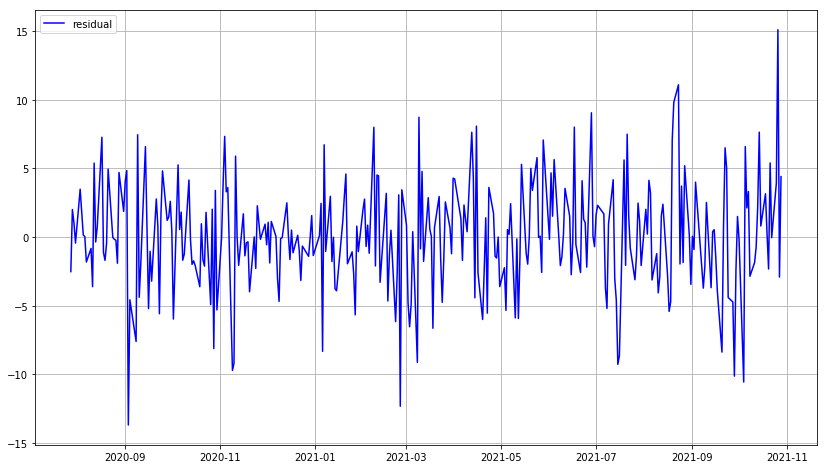

In [ ]:
armares = model_fit.resid
lbvalue,pvalue = acorr_ljungbox(armares,lags=20)
print(pvalue)
plt.figure(figsize=(14,8))
#plt.plot(test_arma.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(datadif.index[:-1], armares, color = 'blue', label = 'residual')
plt.legend()
plt.grid(True)
plt.show()

#pvalue 序列位白噪声

### autocorrelation test on the residuals

In [ ]:
from statsmodels.stats import diagnostic
resid = model_fit.resid
_, pvalue, _, bppvalue = diagnostic.acorr_ljungbox(resid, lags=None, boxpierce=True)
print (pvalue)

[0.99701658 0.95502609 0.60323546 0.71863092 0.80519968 0.71221757
 0.76045538 0.8312504  0.88273925 0.92362742 0.95227659 0.96188353
 0.92252106 0.76258303 0.81761712 0.85097308 0.8888     0.91958492
 0.89028716 0.90256699 0.92876708 0.9469323  0.94529734 0.96068215
 0.86077665 0.75877403 0.79284089 0.8301664  0.84347763 0.8720875
 0.65845229 0.70257758 0.73925887 0.73433346 0.71996637 0.75283428
 0.78953218 0.65961949 0.62082724 0.65027961]
